In [2]:
import pandas as pd
import numpy as np
import datetime

# --- Configuration ---
NUM_ROWS = 1000
np.random.seed(42) # for reproducibility

# --- Generate Time-Based Features ---
start_date = datetime.datetime(2023, 1, 1, 0, 0, 0)
time_deltas = [datetime.timedelta(hours=i) for i in range(NUM_ROWS)]
timestamps = [start_date + delta for delta in time_deltas]

hour_of_day = np.array([ts.hour for ts in timestamps])
day_of_week = np.array([ts.weekday() for ts in timestamps]) # Monday=0, Sunday=6
month = np.array([ts.month for ts in timestamps])

# --- Generate Environmental Features ---
# Outside Temperature (Celsius) - with seasonal and daily variation
seasonal_base_temp = 10 + 15 * np.sin(2 * np.pi * (month - 1 + (hour_of_day / 24) / 30.44 - 3) / 12)
daily_temp_swing = 7 * np.sin(2 * np.pi * (hour_of_day - 9) / 24)
outside_temperature_c = seasonal_base_temp + daily_temp_swing + np.random.normal(0, 2, NUM_ROWS)
outside_temperature_c = np.round(np.clip(outside_temperature_c, -15, 40), 1)

# Relative Humidity (%)
relative_humidity_percent = 60 - (outside_temperature_c - 15) * 1.5 + np.random.normal(0, 10, NUM_ROWS)
relative_humidity_percent = np.round(np.clip(relative_humidity_percent, 20, 95), 1)

# Is Holiday (0 or 1)
is_holiday = np.zeros(NUM_ROWS)
holiday_indices = np.random.choice(np.arange(NUM_ROWS // 24), size=3, replace=False) * 24
for start_idx in holiday_indices:
    is_holiday[start_idx : start_idx + 24] = 1

# --- Generate Target Variable: Energy Consumption (kW) ---
base_consumption = 50
time_effect = 0
time_effect += 30 * np.exp(-((hour_of_day - 9)**2) / (2 * 2**2))
time_effect += 40 * np.exp(-((hour_of_day - 16)**2) / (2 * 3**2))
time_effect[ (hour_of_day < 6) | (hour_of_day > 22) ] *= 0.3

day_effect_multiplier = np.ones(NUM_ROWS)
day_effect_multiplier[day_of_week >= 5] = 0.7

temp_effect = 0
heating_demand = np.maximum(0, 15 - outside_temperature_c)
temp_effect += heating_demand * 2.5
cooling_demand = np.maximum(0, outside_temperature_c - 22)
temp_effect += cooling_demand * 3.0

humidity_effect = np.maximum(0, (relative_humidity_percent - 60) / 100 * cooling_demand * 0.5)
holiday_effect_multiplier = np.where(is_holiday == 1, 0.5, 1.0)

energy_consumption_kw = (base_consumption + time_effect + temp_effect + humidity_effect) * day_effect_multiplier * holiday_effect_multiplier
energy_consumption_kw += np.random.normal(0, base_consumption * 0.05, NUM_ROWS)
energy_consumption_kw = np.round(np.maximum(5, energy_consumption_kw), 2)

# --- Create DataFrame ---
df_energy = pd.DataFrame({
    'Hour_of_Day': hour_of_day,
    'Day_of_Week': day_of_week,
    'Month': month,
    'Outside_Temperature_C': outside_temperature_c,
    'Relative_Humidity_Percent': relative_humidity_percent,
    'Is_Holiday': is_holiday.astype(int),
    'Energy_Consumption_kW': energy_consumption_kw
})

# --- Display and Save ---
print("First 5 rows of the energy consumption dataset:")
print(df_energy.head())
print("\nLast 5 rows of the energy consumption dataset:")
print(df_energy.tail())
print(f"\nShape of the dataset: {df_energy.shape}")
print(f"\nNaN values per column:\n{df_energy.isnull().sum()}")

# Save to TSV
tsv_filename = "energy_consumption_dataset.tsv"
df_energy.to_csv(tsv_filename, sep='\t', index=False) # Key change: sep='\t'
print(f"\nDataset successfully saved to '{tsv_filename}'")
print("You can find this file in the same directory where you ran this Python script.")

First 5 rows of the energy consumption dataset:
   Hour_of_Day  Day_of_Week  Month  Outside_Temperature_C  \
0            0            6      1                   -9.0   
1            1            6      1                  -11.3   
2            2            6      1                  -10.5   
3            3            6      1                   -9.0   
4            4            6      1                  -12.2   

   Relative_Humidity_Percent  Is_Holiday  Energy_Consumption_kW  
0                       95.0           1                  34.65  
1                       95.0           1                  40.18  
2                       95.0           1                  40.02  
3                       89.5           1                  38.59  
4                       95.0           1                  37.31  

Last 5 rows of the energy consumption dataset:
     Hour_of_Day  Day_of_Week  Month  Outside_Temperature_C  \
995           11            5      2                    0.0   
996           1

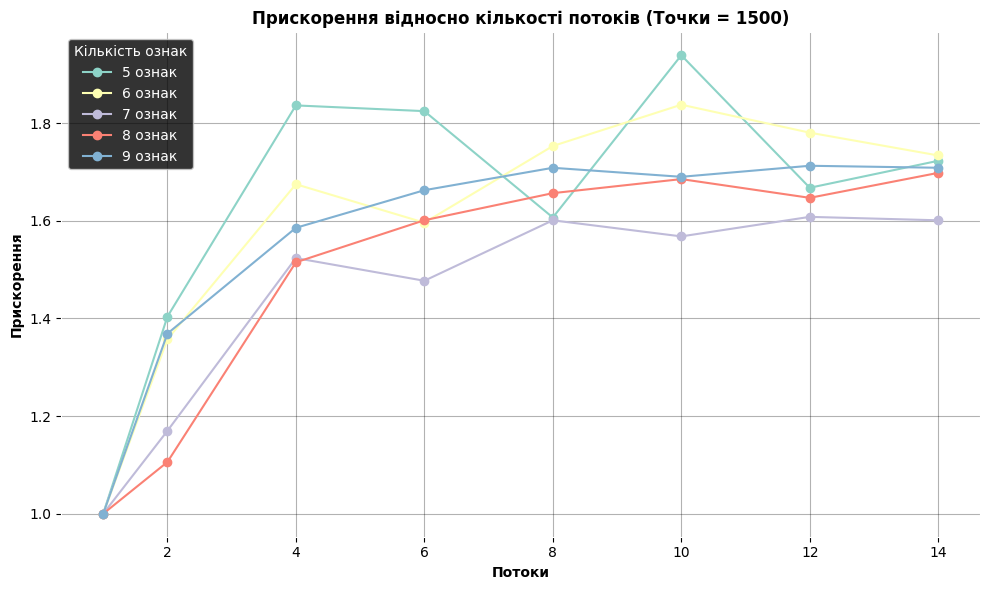

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('time.csv')
df_filtered = df[df['Points'] == 1500]
grouped = df_filtered.pivot(index='Threads', columns='Features', values='Time(ms)')
speedup = grouped.iloc[0] / grouped

plt.figure(figsize=(10, 6), facecolor='white')
plt.gca().set_facecolor('white')
for feature in speedup.columns:
    plt.plot(speedup.index, speedup[feature], marker='o', label=f'{feature} ознак')

plt.title('Прискорення відносно кількості потоків (Точки = 1500)', color='black', fontweight='bold')
plt.xlabel('Потоки', color='black', fontweight='bold')
plt.ylabel('Прискорення', color='black', fontweight='bold')
plt.grid(True, color='black', alpha=0.3, linewidth=0.8)
plt.legend(title='Кількість ознак')
plt.tick_params(axis='both', colors='black')
plt.tight_layout()
plt.savefig("gen_data.jpg", dpi=100, facecolor='white')
plt.show()

C:\Users\captain\AppData\Local\Temp\ipykernel_20244\446047347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Speedup'] = baseline_time / df_filtered['Time(ms)']


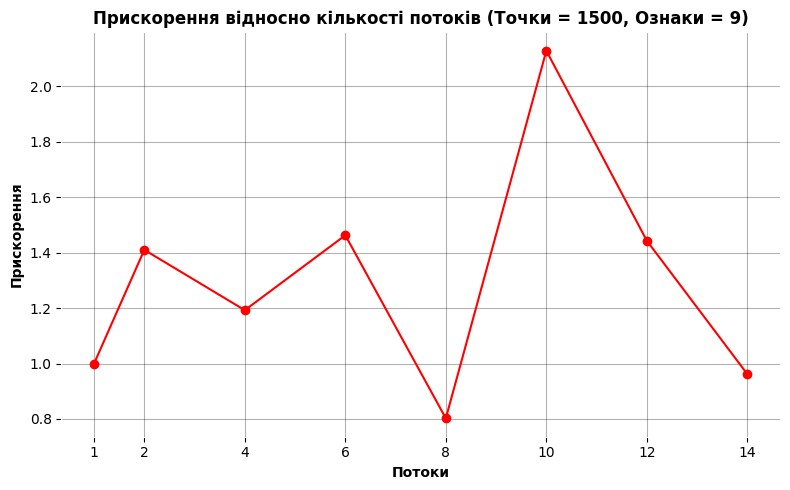

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('energy.csv')
df_filtered = df[(df['Points'] == 1500) & (df['Features'] == 9)]
baseline_time = df_filtered.loc[df_filtered['Threads'] == 1, 'Time(ms)'].values[0]
df_filtered['Speedup'] = baseline_time / df_filtered['Time(ms)']

plt.figure(figsize=(8, 5), facecolor='white')
plt.gca().set_facecolor('white')
plt.plot(df_filtered['Threads'], df_filtered['Speedup'], marker='o', linestyle='-', color='red')
plt.title('Прискорення відносно кількості потоків (Точки = 1500, Ознаки = 9)', color='black', fontweight='bold')
plt.xlabel('Потоки', color='black', fontweight='bold')
plt.ylabel('Прискорення', color='black', fontweight='bold')
plt.grid(True, color='black', alpha=0.3, linewidth=0.8)
plt.xticks(df_filtered['Threads'])
plt.tick_params(axis='both', colors='black')
plt.tight_layout()
plt.savefig("graph_concrete.jpg", dpi=100, facecolor='white')
plt.show()